In [1]:
# Get traces from mika's factorized 2-color datasets
import matplotlib.pyplot as plt
import numpy as np
import h5py
import nibabel as nib
from scipy.signal import decimate,detrend
from fish.util.fileio import read_image
from fish.util.plot import proj_fuse

In [2]:
def stackline(x_axis, array, axis, scale, **kwargs):
    for ind, val in enumerate(array):
        axis.plot(x_axis, val - ind * scale, **kwargs)
    axis.set_xlim(x_axis.min(), x_axis.max())

def load_muy_mat(fname, head_name='data'):
    from h5py import File 
    from numpy import squeeze
    data = {}
    with File(fname) as f: 
        for k in f[head_name].keys():
            data[k] = squeeze(f[head_name][k][:])
    return data

def get_roi_mean(fn, masks):
    from fish.util.fileio import read_image
    data = read_image(fn)
    data_ = {}
    data_['g'] = data[:,:data.shape[1]//2]
    data_['n'] = data[:,data.shape[1]//2:]
    masked_means = {k: np.array([data_[k][mask].mean() for mask in v]) for k, v in masks.items()}
    return masked_means

In [3]:
potential_paths = ['/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/',
                   '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish3/20170228_3_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_165730/',
                  '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170221/fish5/20170221_5_2_gfaprgeco_hucgc_6dpf_wholebrain_20170221_220811/',
                  '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170221/fish5/20170221_5_3_gfaprgeco_hucgc_6dpf_wholebrain_20170221_223941/']

import sys
import json
import pathlib as pl
from os.path import sep
from glob import glob
dirs = {}
dirs['base'] = potential_paths[0]
anat_ref = read_image(glob(dirs['base'] + '*anat_reference*.tif')[0])
exp_name = dirs['base'].split(sep)[-2]
dirs['ephys'] = dirs['base'] + 'ephys/'
dirs['raw'] = dirs['base'] + 'raw/'
dirs['dff'] = '/groups/ahrens/ahrenslab/davis/tmp/' + exp_name + '/projections/dff/'
dirs['output'] = '/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/'

with open(dirs['dff'] + 'metadata.json', 'r') as f:
    metadata = json.load(f)
dff_lims = metadata['dff_lims']
from fish.image.vol import get_stack_freq
fs_im = get_stack_freq(dirs['raw'])[0]

fnames = sorted(glob(dirs['dff'] + '*.tif'))

print(len(fnames))

7200


In [4]:
epdat = load_muy_mat(dirs['ephys'] + 'data.mat')
epdat_raw = load_muy_mat(dirs['ephys'] + 'rawdata.mat', head_name='rawdata')
swims = epdat['fltCh1'] + epdat['fltCh2']
cam = np.where(np.diff(epdat['frame']))[0][:len(fnames)]
fs_ep = 6000

In [5]:
%%time 

from skimage.transform import downscale_local_mean
from dipy.align.imaffine import transform_centers_of_mass, MutualInformationMetric, AffineRegistration
from dipy.align.transforms import TranslationTransform3D,RigidTransform3D,AffineTransform3D
# make dimension order [z y x]
# this image is 0-padded with 8 z planes, 4 top and 4 bottom, so remove those
ds_mika = 2
shave = slice(4,-4)
template_mika = nib.load('/groups/ahrens/ahrenslab/mika/yu/data/twoc/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/ana/image_reference_aligned0.nii.gz').get_data()
static = template_mika.T[shave]

moving = downscale_local_mean(anat_ref, (1,ds_mika,ds_mika))
# take first half of y-range
moving = moving[:,:moving.shape[1]//2,:]

g2w_ds = np.eye(4)

c_of_mass = transform_centers_of_mass(static, g2w_ds, moving, g2w_ds)
metric_lin = MutualInformationMetric(32, None)

level_iters = [10000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]
params0 = None

affreg = AffineRegistration(metric=metric_lin, level_iters=level_iters, sigmas=sigmas, factors=factors, verbosity=0, ss_sigma_factor=1.0)
translation = affreg.optimize(static, moving, TranslationTransform3D(), params0, g2w_ds, g2w_ds,starting_affine=c_of_mass.affine)

CPU times: user 2min 13s, sys: 7.81 s, total: 2min 21s
Wall time: 2min 22s


In [6]:
print(translation.affine)

[[ 1.          0.          0.         -0.05298145]
 [ 0.          1.          0.         -0.48038858]
 [ 0.          0.          1.         -1.76217267]
 [ 0.          0.          0.          1.        ]]


In [7]:
shifts_zyx = translation.affine[:-1,-1]

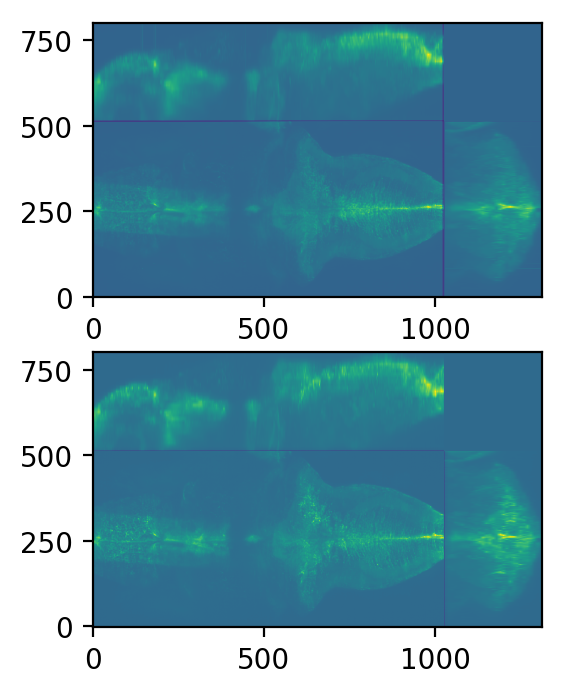

In [8]:
fig, axs = plt.subplots(nrows=2, dpi=200)
axs[0].imshow(proj_fuse(static, np.max, (10,1,1), fill_value=100), origin='lower')
axs[1].imshow(proj_fuse(translation.transform(moving), np.max, (10,1,1), fill_value=100), origin='lower')

In [9]:
%%time

mask_fnames = {} 
mask_fnames['g'] = sorted(glob('/groups/ahrens/ahrenslab/mika/yu/data/twoc/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/ana/binary_masks0/*.nii.gz'))
mask_fnames['n'] = sorted(glob('/groups/ahrens/ahrenslab/mika/yu/data/twoc/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/ana/binary_masks1/*.nii.gz'))

shifts=  shifts_zyx
# mika's data are padded with 4 planes on the top and the bottom. this slice removes them.
shave = slice(4,-4)
def shifter(data, shifts=shifts):
    from scipy.ndimage.interpolation import shift
    return shift(data.astype('int'), shifts)

masks = {k: np.array([shifter(nib.load(m).get_data().T[shave]).astype('bool') for m in v]) for k,v in mask_fnames.items()}

CPU times: user 4min 52s, sys: 3.87 s, total: 4min 56s
Wall time: 4min 56s


In [10]:
comp_ts = {}
with h5py.File('/groups/ahrens/ahrenslab/mika/yu/data/twoc/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/ana/Binary_mask_vectors_0.mat') as fn:
    comp_ts['g'] = fn['Hm'][:]
with h5py.File('/groups/ahrens/ahrenslab/mika/yu/data/twoc/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/ana/Binary_mask_vectors_1.mat') as fn:
    comp_ts['n'] = fn['Hm'][:]

In [25]:
%%time
from multiprocessing import Pool
from functools import partial

def get_masked_data(fn, masks):
    from fish.util.fileio import read_image
    from numpy import array
    tmp = read_image(fn)
    data = dict(g=tmp[:,:tmp.shape[1]//2, :], n=tmp[:,(tmp.shape[1]//2):, :])
    masked_data = {k : array([data[k][m].mean() for m in val]) for k,val in masks.items()}
    return masked_data

parf = partial(get_masked_data, masks=masks)

with Pool(10) as p:
    results = p.map(parf, fnames)

CPU times: user 11.8 s, sys: 20.4 s, total: 32.1 s
Wall time: 9min 16s


In [38]:
np.array([r['g'] for r in results]).shape

(7200, 12)

In [43]:
# convert single timepoints to arrays
roi_ts = {k: np.array([r[k] for r in results]) for k in results[-1].keys()}

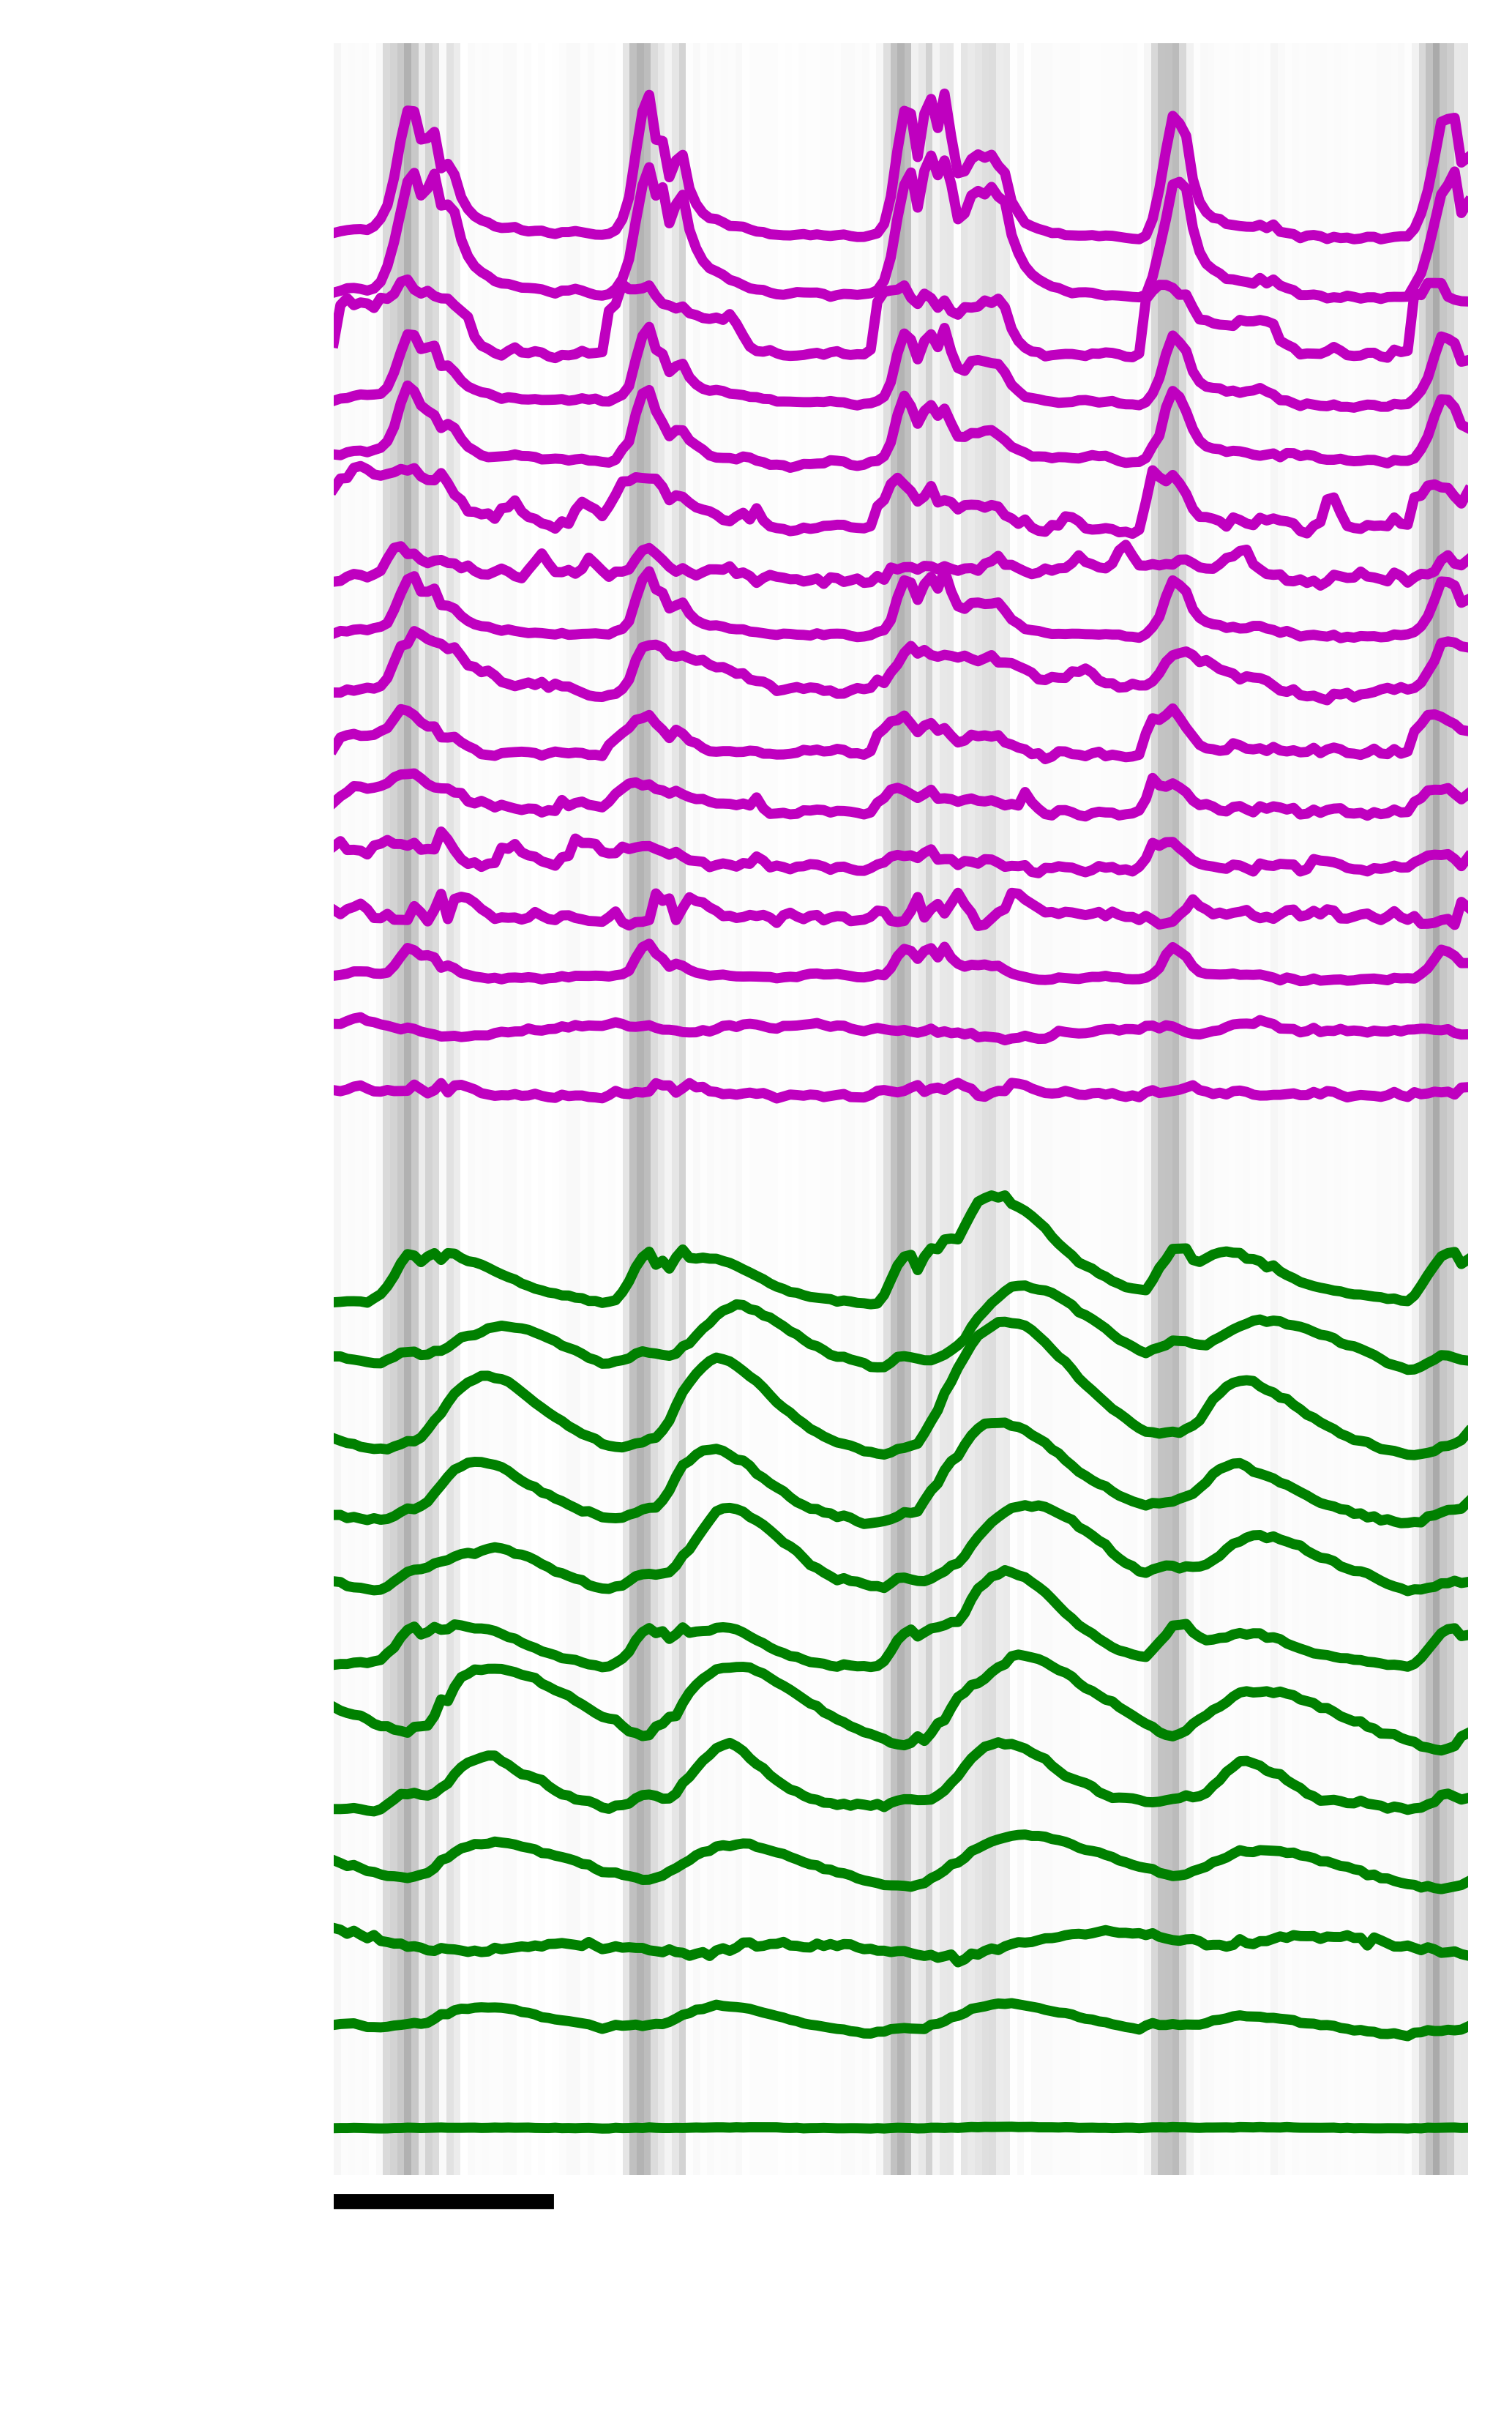

In [45]:
fs_ep = 6000
import matplotlib
matplotlib.style.use('presentation')
fig, axs = plt.subplots(figsize=(4,8), nrows=2, sharex=True, dpi=500)
framerange = np.arange(580,750)
x_axis_im = cam[framerange] / fs_ep
ds_ep = 10
plr_ep = np.arange(cam[framerange[0]], cam[framerange[-1]], ds_ep)
x_axis_ep = plr_ep / fs_ep
valid_comps = {}
valid_comps['n'] = np.argsort(roi_ts['n'].var(0))[::-1]
valid_comps['g'] = np.argsort(roi_ts['g'].var(0))[::-1]
gens = ['n','g']
colors={}
colors['n'] = 'm'
colors['g'] = 'g'

swimage = decimate(detrend(swims[plr_ep]), 400, ftype='fir').reshape(1,-1)
clim=(swimage.min() - 0 * swimage.ptp(), swimage.max() + 2 * swimage.ptp())
for ind, ax in enumerate(axs):
    stackline(x_axis_im, roi_ts[gens[ind]][framerange][:, valid_comps[gens[ind]]].T, ax, scale=100, linewidth=2, color=colors[gens[ind]])
    lims = ax.get_xlim(), ax.get_ylim()
    ax.imshow(swimage, extent=(lims[0][0], lims[0][1], lims[1][0],  lims[1][1]), aspect='auto', cmap='gray_r', clim=clim)

axs[0].axis('off')
axs[-1].axis('off')
plt.subplots_adjust(hspace=0)

# y-axis scalebar
axs[-1].plot(2 * [1.01 * axs[-1].get_xlim()[0]], [axs[-1].get_ylim()[0], axs[-1].get_ylim()[0] + .05], color='k', linewidth=3)

# x-scalebar
axs[-1].plot((axs[-1].get_xlim()[0], axs[-1].get_xlim()[0] + 20), 2 * [1.05 * axs[-1].get_ylim()[0]], color='k', linewidth=3)

In [ ]:
fs_ep = 6000
import matplotlib
matplotlib.style.use('presentation')
fig, axs = plt.subplots(figsize=(4,8), nrows=2, sharex=True)
framerange = np.arange(580,750)
x_axis_im = cam[framerange] / fs_ep
ds_ep = 10
plr_ep = np.arange(cam[framerange[0]], cam[framerange[-1]], ds_ep)
x_axis_ep = plr_ep / fs_ep
valid_comps = {}
valid_comps['n'] = np.argsort(ts['n'].var(0))[::-1]
valid_comps['g'] = np.argsort(ts['g'].var(0))[::-1]
gens = ['n','g']
colors={}
colors['n'] = 'm'
colors['g'] = 'g'

swimage = decimate(detrend(swims[plr_ep]), 400, ftype='fir').reshape(1,-1)
clim=(swimage.min() - 0 * swimage.ptp(), swimage.max() + 2 * swimage.ptp())
for ind, ax in enumerate(axs):
    stackline(x_axis_im, ts[gens[ind]][framerange][:, valid_comps[gens[ind]]].T, ax, scale=.12, linewidth=2, color=colors[gens[ind]])
    lims = ax.get_xlim(), ax.get_ylim()
    ax.imshow(swimage, extent=(lims[0][0], lims[0][1], lims[1][0],  lims[1][1]), aspect='auto', cmap='gray_r', clim=clim)

axs[0].axis('off')
axs[-1].axis('off')
plt.subplots_adjust(hspace=0)

# y-axis scalebar
axs[-1].plot(2 * [1.01 * axs[-1].get_xlim()[0]], [axs[-1].get_ylim()[0], axs[-1].get_ylim()[0] + .05], color='k', linewidth=3)

# x-scalebar
axs[-1].plot((axs[-1].get_xlim()[0], axs[-1].get_xlim()[0] + 20), 2 * [1.05 * axs[-1].get_ylim()[0]], color='k', linewidth=3)

In [ ]:
## get a chunk of data, plot an roi mean from that chunk vs the component corresponding to that ROI

In [ ]:
%%time
# load a chunk
roi_ = (slice(10, None), slice(100, 400), slice(800, None))
from skimage.io import imread
from multiprocessing import Pool
from functools import partial

def roiload(fname, roi):
    from skimage.io import imread
    return imread(fname)[roi]

parf = partial(roiload, roi=roi_)

with Pool(10) as p:
    dff = np.array(p.map(parf, fnames))

# get the mean of the chunk that overlaps with the roi
gen = 'g'
comp = 11
mask_cropped = masks[gen][comp][roi_]
roi_mean = np.array([d[mask_cropped].mean() for d in dff])

gen = 'g'
comp = 11
plr_cam = np.arange(100, 1900)
x_axis_im = cam[plr_cam]
fig, axs = plt.subplots(ncols = 2, figsize = (16,8))
axs[0].imshow(500 * masks[gen][comp].std(0).T + moving.max(0).T, cmap='gray')
axs[1].plot(x_axis_im, comp_ts[gen][plr_cam, comp])
axs[1].twinx().plot(x_axis_im, roi_mean[plr_cam], color='y')